In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## Reading time series data and check if the data type is datetime

In [2]:
df=pd.read_csv('dailysales.csv',parse_dates=['date'])

In [3]:
df.info() # date format 
# checking the data to see if it fits time series data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    704 non-null    datetime64[ns]
 1   sales   704 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.1 KB


In [4]:
df.head() 

,date,sales
0,2018-01-01,477.0
1,2018-01-02,365.0
2,2018-01-03,442.0
3,2018-01-04,490.0
4,2018-01-05,396.0


## Handling missing values

In [5]:
#check if there is missing values
df.isnull().sum()
# as there is no null then we can go ahead 
# inputing: if there are any missing values, back ro forwarding fill works

date     0
sales    0
dtype: int64

## Data structure
- In time series, I need to aggregate the data. 
- For example, according to business requirement I might have to group daily data into yearly, quarterly or monthly. 
- this data is daily. in excel I can group using pivot 
- in python, I am using 2 fucntions
- 1. groupby() by date-> take sum
- 2. resample()

In [6]:
df=df.groupby('date').sum()
# I am grouping by as there can be multiple entries for one date
# also, I am converting date as index
# to work with timeseries, I need to have date as index.

In [7]:
df.head(10)

,sales
date,
2018-01-01,477.0
2018-01-02,365.0
2018-01-03,442.0
2018-01-04,490.0
2018-01-05,396.0
2018-01-06,385.0
2018-01-07,492.0
2018-01-08,473.0
2018-01-09,249.0


#### resample()
- Pandas dataframe.resample() function is primarily used for time series data
- W : weekly frequency
- M : month end frequency
- SM : semi-month end frequency (15th and end of month)
- Q : quarter end frequency
- D: daily
- A: year end

In [8]:
# converting daily to monthly sales
# how to aggregate the date we take the sum or the mean?
df=df.resample(rule='MS').sum() # rule & aggregation parameter
# MS stands for month start
# in last output I got date in month

In [9]:
df.head(10)
# daily sales are conerted into monthly and with date starts

,sales
date,
2018-01-01,9035.0
2018-02-01,9571.0
2018-03-01,13143.0
2018-04-01,12427.0
2018-05-01,8133.0
2018-06-01,7437.0
2018-07-01,11758.0
2018-08-01,9992.0
2018-09-01,7216.0


<AxesSubplot:xlabel='date'>

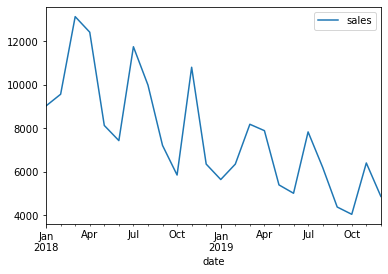

In [10]:
df.plot()
# checking the data trend and seasonlity: Downward trend and there is seasonality

In [11]:
# to separate seasonality and trend, I am using api from statsmodel
# using decompose() :Seasonal decomposition using moving averages.
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

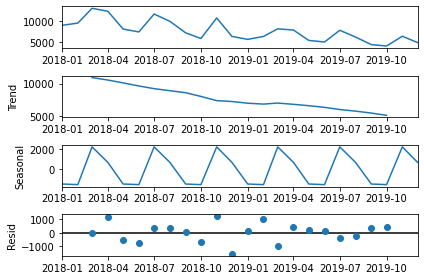

In [13]:
#seasonal_decompose(df,model='additive',freq=4).plot();freq is old parameter

seasonal_decompose(df,model='additive',period=4).plot();
# As I am getting strong quarterly seasonlity hence considering additve 

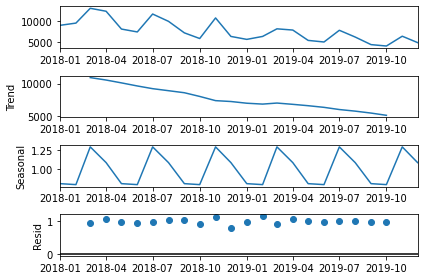

In [15]:
seasonal_decompose(df,model='multiplicative',period=4).plot();

- Additive trend means the trend is linear (straight line)
- multiplicative seasonality means there are changes to widths or heights of seasonal periods over time.
- so my trend is linear here and seasonal has pattern so multiplicative. 
- Using the same for arguments ( can be hyper parameters ) while building model

### Train test Split

In [16]:
train=df[:19] #till Jul19
test=df[19:] # from aug19

In [17]:
train.tail()

,sales
date,
2019-03-01,8188.55
2019-04-01,7894.25
2019-05-01,5397.40
2019-06-01,5012.80
2019-07-01,7837.30


In [18]:
test # august to Dec

,sales
date,
2019-08-01,6207.00
2019-09-01,4379.25
2019-10-01,4043.45
2019-11-01,6406.95
2019-12-01,4867.25


## Applying Holt Winters Model

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
hwmodel=ExponentialSmoothing(train.sales,trend='add', seasonal='mul', seasonal_periods=4).fit()
# passign training data, if trend is add or mul and seasonality is add or mul
# add and mul are hyperparamter tuning
# as it is quarterly seasonal, seasonal_period= 4
#fitting model

In [28]:
test_pred=hwmodel.forecast(5)
# predicting for next 5 months. (after last month of traininf data)
# that is, last training data is on july and next 5 months from July

In [29]:
test_pred

2019-08-01    6036.915032
2019-09-01    4132.161459
2019-10-01    3935.326147
2019-11-01    5994.175247
2019-12-01    4927.945274
Freq: MS, dtype: float64

<AxesSubplot:xlabel='date'>

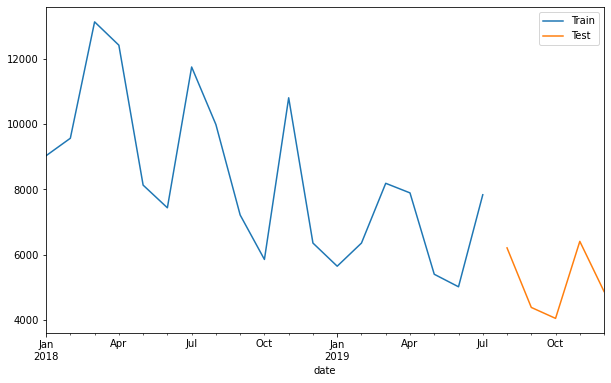

In [31]:
#plotting actual train data and test data

train['sales'].plot(legend=True, label='Train', figsize=(10,6))
test['sales'].plot(legend=True, label='Test')



<AxesSubplot:xlabel='date'>

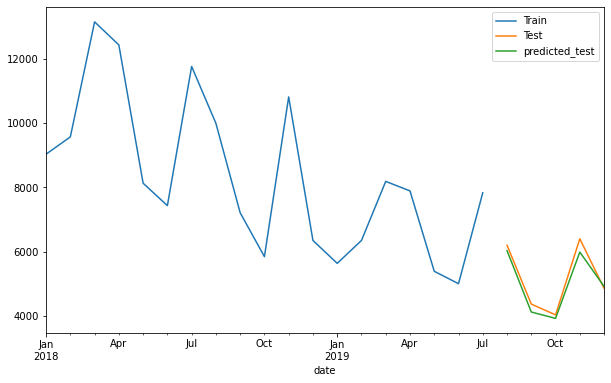

In [33]:
# plotting train test and predicted data

train['sales'].plot(legend=True, label='Train', figsize=(10,6))
test['sales'].plot(legend=True, label='Test')
test_pred.plot(legend=True, label='predicted_test')

## Model Evaluation in Time Series
- using root mean_square error
- First calculare mean_squared_error then apply square root over it

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
np.sqrt(mean_squared_error(test,test_pred))
# I got sqrt but how to know if it is good model

234.83582507475032

In [40]:
# compare mean and standard deviation
df.sales.mean(), np.sqrt(df.sales.var())

(7665.204166666666, 2549.757117414906)

- I calculated mean and std deviation.
- Comparing these to the RMSE which is 234
- I can say that there is large difference and my model is good
- Model was built on train data. Now building model taking entire data

## Final Model
- Passing entire data (rather than test train) 

In [41]:
final_model=ExponentialSmoothing(df.sales,trend='add', seasonal='mul', seasonal_periods=4).fit()

In [42]:
pred=final_model.forecast(4)

In [43]:
pred

2020-01-01    3524.018735
2020-02-01    3319.791332
2020-03-01    4961.299873
2020-04-01    4022.591817
Freq: MS, dtype: float64

<AxesSubplot:xlabel='date'>

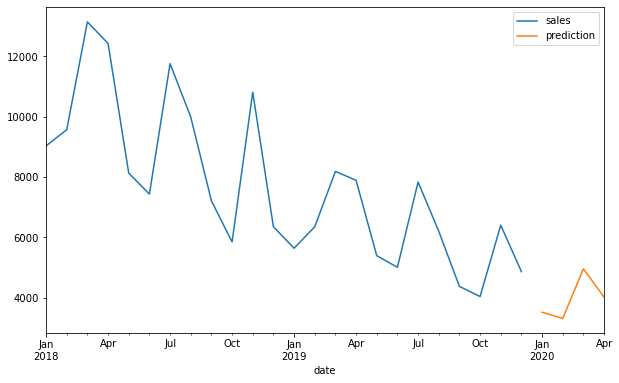

In [44]:
#plotting original data and forecasted data

df['sales'].plot(legend=True, label='sales', figsize=(10,6))
pred.plot(legend=True, label='prediction')